In [1]:
import os
from google.colab import drive

In [2]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Change working directory to your file position
path = "/content/gdrive/My Drive/diseaseDiagnosis"
os.chdir(path)

# Confirm the change
print("Working Directory:", os.getcwd())

Working Directory: /content/gdrive/My Drive/diseaseDiagnosis


In [4]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
from scipy.spatial.distance import cosine
import random

import os
import shutil
import sys
from math import floor

import numpy
import numpy as np
import sklearn
from scipy import spatial
from sklearn.model_selection import train_test_split, KFold

""""""
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')

from pathlib import Path
import matplotlib.pyplot as plt


/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
class SymptomsDiagnosis:
    CONST_HADM_ID = 0
    CONST_SUBJECT_ID = 1
    CONST_ADMITTIME = 2
    CONST_DISCHTIME = 3
    CONST_SYMPTOMS = 4
    CONST_DIAGNOSIS = 5

    def __init__(self, hadm_id, subject_id, admittime, dischtime, symptoms, diagnosis):
        self.hadm_id = hadm_id
        self.subject_id = subject_id
        self.admittime = admittime
        self.dischtime = dischtime
        self.symptoms = symptoms
        self.diagnosis = diagnosis

def preprocess_diagnosis(diagnosis):
    return diagnosis.lower()

# Compute embedding for symptoms
def embending_symptoms(model, admissions):
    embendings = {}
    for hadm_id, admission in admissions.items():
        symptoms = admission.symptoms  # Direct attribute access
        embendings[hadm_id] = model.encode(symptoms)  # Encoding using the model
    return embendings

# Compute embedding for diagnosis
def embending_diagnosis(model, admissions):
    embendings = {}
    for hadm_id, admission in admissions.items():
        diagnosis = admission.diagnosis  # Direct attribute access
        embendings[hadm_id] = model.encode(diagnosis)  # Encoding using the model
    return embendings


In [6]:
file_name = os.getcwd() + "/Symptoms-Diagnosis.txt"
f = open(file_name, "r").readlines()
orig_stdout = sys.stdout

admissions = dict()
for line in f:
    line.replace("\n", "")
    attributes = line.split(';')
    a = SymptomsDiagnosis(attributes[SymptomsDiagnosis.CONST_HADM_ID], attributes[SymptomsDiagnosis.CONST_SUBJECT_ID], attributes[SymptomsDiagnosis.CONST_ADMITTIME],
                                                   attributes[SymptomsDiagnosis.CONST_DISCHTIME], attributes[SymptomsDiagnosis.CONST_SYMPTOMS],
                                                   preprocess_diagnosis(attributes[SymptomsDiagnosis.CONST_DIAGNOSIS]))
    admissions.update({attributes[SymptomsDiagnosis.CONST_HADM_ID]:a})


In [7]:
model = SentenceTransformer('emilyalsentzer/Bio_ClinicalBERT')  # Choose a lightweight model
################################################################################################################
#COMPUTE EMBENDINGS
################################################################################################################
embendings_symptoms = embending_symptoms(model,admissions)
embendings_diagnosis = embending_diagnosis(model,admissions)

# Constants for evaluation
TOP_K_VALUES = [5, 10, 15, 20, 25, 30]
SYMPTOMS_SIMILARITY_THRESHOLD = 0.9
DIAGNOSIS_SIMILARITY_THRESHOLD = 0.9

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [10]:
from sklearn.model_selection import KFold
import numpy as np

# Function for K-Fold Cross Validation
def k_fold_cross_validation(admissions, embending_symptoms, embending_diagnosis, k=5, top_k_values=TOP_K_VALUES):
    admission_ids = list(admissions.keys())
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    precision_scores_kfold = {k: [] for k in top_k_values}
    recall_scores_kfold = {k: [] for k in top_k_values}
    f1_scores_kfold = {k: [] for k in top_k_values}

    for fold, (train_index, test_index) in enumerate(kf.split(admission_ids)):
        print(f"Fold {fold + 1}/5")

        # Split train and test based on indices
        train_ids = [admission_ids[i] for i in train_index]
        test_ids = [admission_ids[i] for i in test_index]

        train_admissions = {id_: admissions[id_] for id_ in train_ids}
        test_admissions = {id_: admissions[id_] for id_ in test_ids}
        train_embending_symptoms = {id_: embending_symptoms[id_] for id_ in train_ids}
        test_embending_symptoms = {id_: embending_symptoms[id_] for id_ in test_ids}
        train_embending_diagnosis = {id_: embending_diagnosis[id_] for id_ in train_ids}
        test_embending_diagnosis = {id_: embending_diagnosis[id_] for id_ in test_ids}

        # Evaluate the current fold
        precision_scores, recall_scores, f1_scores = evaluate_model(
            train_admissions, test_admissions,
            train_embending_symptoms, test_embending_symptoms,
            train_embending_diagnosis, test_embending_diagnosis,
            top_k_values
        )

        # Aggregate metrics across folds
        for k in top_k_values:
            precision_scores_kfold[k].append(precision_scores[k])
            recall_scores_kfold[k].append(recall_scores[k])
            f1_scores_kfold[k].append(f1_scores[k])

    # Calculate average metrics across folds
    avg_precision_scores = {k: np.mean(precision_scores_kfold[k]) for k in top_k_values}
    avg_recall_scores = {k: np.mean(recall_scores_kfold[k]) for k in top_k_values}
    avg_f1_scores = {k: np.mean(f1_scores_kfold[k]) for k in top_k_values}

    # Display results
    print("\nK-Fold Cross Validation Results (Averaged Across Folds):")
    for k in top_k_values:
        print(f"Top-{k} Results:")
        print(f"Precision: {avg_precision_scores[k]:.4f}, Recall: {avg_recall_scores[k]:.4f}, F1-Score: {avg_f1_scores[k]:.4f}")
        print("-" * 40)

def train_test_split_admissions(admissions, embending_symptoms, embending_diagnosis, test_ratio=0.2):
    admission_ids = list(admissions.keys())
    random.shuffle(admission_ids)
    split_index = int(len(admission_ids) * (1 - test_ratio))

    train_ids = admission_ids[:split_index]
    test_ids = admission_ids[split_index:]

    train_admissions = {id_: admissions[id_] for id_ in train_ids}
    test_admissions = {id_: admissions[id_] for id_ in test_ids}
    train_embending_symptoms = {id_: embending_symptoms[id_] for id_ in train_ids}
    test_embending_symptoms = {id_: embending_symptoms[id_] for id_ in test_ids}
    train_embending_diagnosis = {id_: embending_diagnosis[id_] for id_ in train_ids}
    test_embending_diagnosis = {id_: embending_diagnosis[id_] for id_ in test_ids}

    return train_admissions, test_admissions, train_embending_symptoms, test_embending_symptoms, train_embending_diagnosis, test_embending_diagnosis



In [11]:

# Calculate cosine similarity between two vectors
def calculate_similarity(vec1, vec2):
    return 1 - cosine(vec1, vec2)

# Evaluate the model for each fold's test data against all training data
def evaluate_model(train_admissions, test_admissions, train_embending_symptoms, test_embending_symptoms, train_embending_diagnosis, test_embending_diagnosis, top_k_values=TOP_K_VALUES):
    precision_scores, recall_scores, f1_scores = {}, {}, {}
    for k in top_k_values:
        precision_scores[k] = []
        recall_scores[k] = []
        f1_scores[k] = []

    # Loop through each test admission
    for test_id, test_admission in test_admissions.items():
        test_symptom_embed = test_embending_symptoms[test_id]
        test_diag_embed = test_embending_diagnosis[test_id]

        # Compute similarities with all train admissions
        similarity_scores = []
        for train_id, train_admission in train_admissions.items():
            train_symptom_embed = train_embending_symptoms[train_id]
            train_diag_embed = train_embending_diagnosis[train_id]

            # Calculate average similarity between symptoms and diagnoses
            symptom_similarity = calculate_similarity(test_symptom_embed, train_symptom_embed)
            diag_similarity = calculate_similarity(train_diag_embed, test_diag_embed)

            # Check if similarity scores pass the threshold
            if symptom_similarity >= SYMPTOMS_SIMILARITY_THRESHOLD:
              similarity_scores.append((train_id, symptom_similarity,diag_similarity))
        # Sort scores and select top-k predictions
        similarity_scores.sort(key=lambda x: x[1], reverse=True)

        for k in top_k_values:
            top_k_predictions = [x[2] for x in similarity_scores[:k]]
            true_positive = len([i for i in top_k_predictions if i>DIAGNOSIS_SIMILARITY_THRESHOLD])
            fn = [x[2] for x in similarity_scores[k:50]]
            fn = len([i for i in fn if i>DIAGNOSIS_SIMILARITY_THRESHOLD])

            # Calculate precision, recall, and F1
            precision = true_positive/k
            recall = true_positive /(fn+true_positive+0.000000001)
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

            precision_scores[k].append(precision)
            recall_scores[k].append(recall)
            f1_scores[k].append(f1)

    # Print the average metrics for each top-k
    for k in top_k_values:
        avg_precision = np.mean(precision_scores[k])
        avg_recall = np.mean(recall_scores[k])
        avg_f1 = np.mean(f1_scores[k])

        precision_scores[k] = avg_precision
        recall_scores[k] = avg_recall
        f1_scores[k] = avg_f1
        print(f"Top-{k} Results:")
        print(f"Precision: {avg_precision:.4f}, Recall: {avg_recall:.4f}, F1-Score: {avg_f1:.4f}")
        print("-" * 40)

    plt.figure(figsize=(8, 6))
    plt.plot(top_k_values, list(precision_scores.values()), marker='o', label="Precision")
    plt.xlabel("Top-K")
    plt.ylabel("Precision")
    plt.title("Precision vs Top-K")
    plt.grid()
    plt.show()

    # Plot Recall vs Top-K
    plt.figure(figsize=(8, 6))
    plt.plot(top_k_values,list(recall_scores.values()) , marker='o', label="Recall", color='orange')
    plt.xlabel("Top-K")
    plt.ylabel("Recall")
    plt.title("Recall vs Top-K")
    plt.grid()
    plt.show()

    # Plot F1 Score vs Top-K
    plt.figure(figsize=(8, 6))
    plt.plot(top_k_values,list(f1_scores.values()) , marker='o', label="F1 Score", color='green')
    plt.xlabel("Top-K")
    plt.ylabel("F1 Score")
    plt.title("F1 Score vs Top-K")
    plt.grid()
    plt.show()
    return precision_scores, recall_scores, f1_scores


Fold 1/5
Top-5 Results:
Precision: 0.5619, Recall: 0.1123, F1-Score: 0.1790
----------------------------------------
Top-10 Results:
Precision: 0.5667, Recall: 0.2340, F1-Score: 0.3105
----------------------------------------
Top-15 Results:
Precision: 0.5556, Recall: 0.3529, F1-Score: 0.3997
----------------------------------------
Top-20 Results:
Precision: 0.5429, Recall: 0.4485, F1-Score: 0.4569
----------------------------------------
Top-25 Results:
Precision: 0.5410, Recall: 0.5547, F1-Score: 0.5111
----------------------------------------
Top-30 Results:
Precision: 0.5302, Recall: 0.6435, F1-Score: 0.5440
----------------------------------------


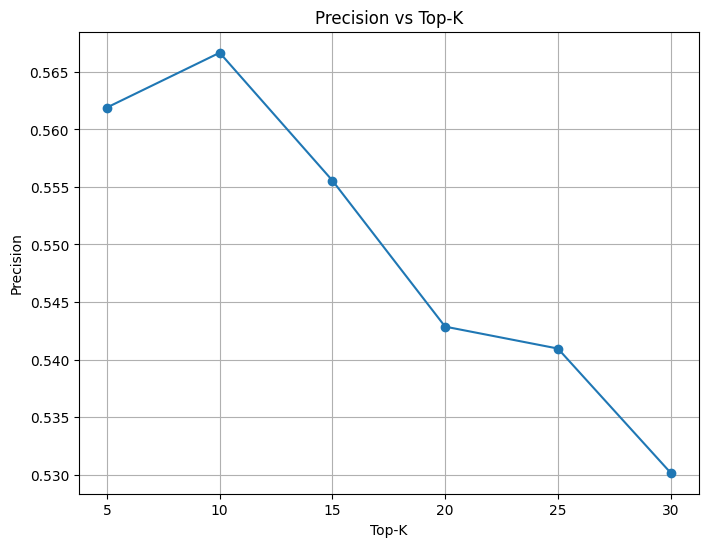

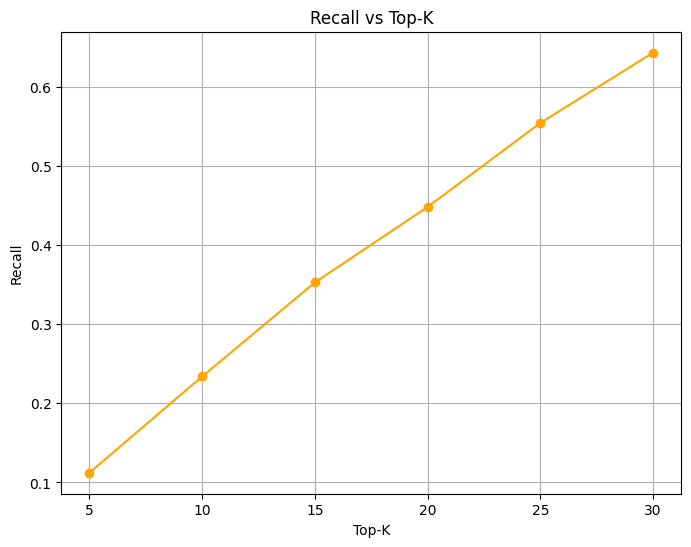

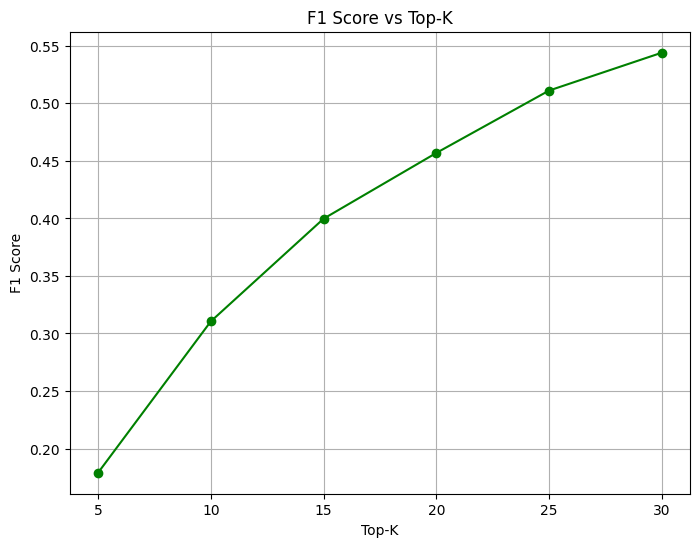

Fold 2/5
Top-5 Results:
Precision: 0.5619, Recall: 0.1071, F1-Score: 0.1764
----------------------------------------
Top-10 Results:
Precision: 0.5619, Recall: 0.2182, F1-Score: 0.3046
----------------------------------------
Top-15 Results:
Precision: 0.5619, Recall: 0.3266, F1-Score: 0.3992
----------------------------------------
Top-20 Results:
Precision: 0.5476, Recall: 0.4241, F1-Score: 0.4602
----------------------------------------
Top-25 Results:
Precision: 0.5314, Recall: 0.5095, F1-Score: 0.5020
----------------------------------------
Top-30 Results:
Precision: 0.5222, Recall: 0.6003, F1-Score: 0.5390
----------------------------------------


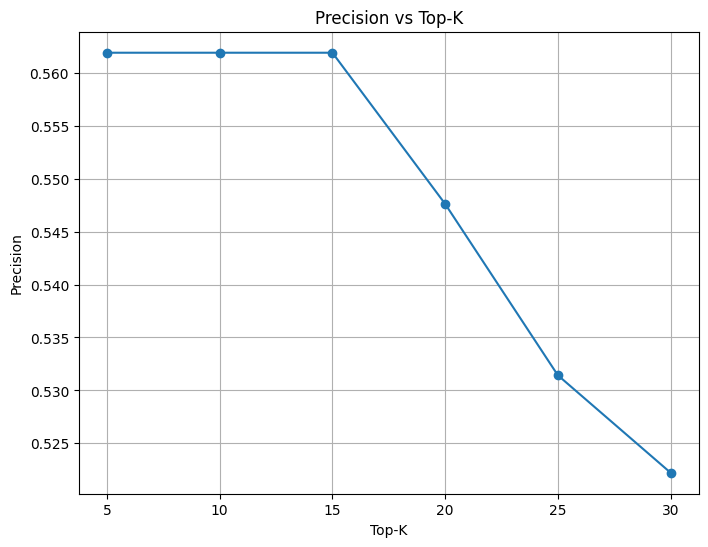

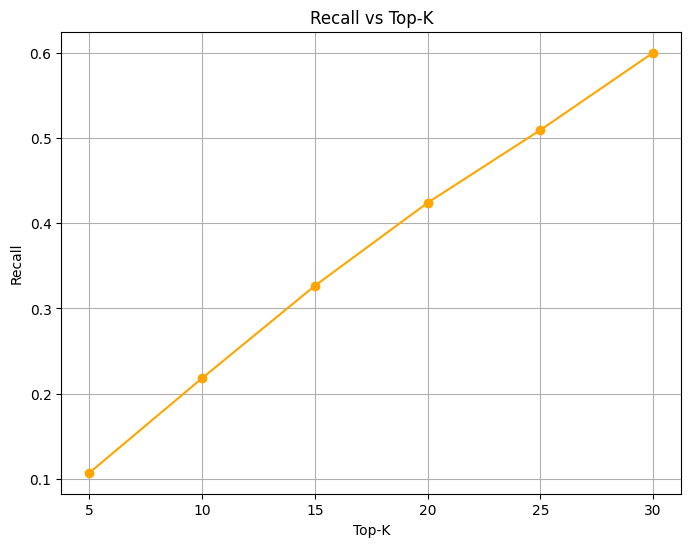

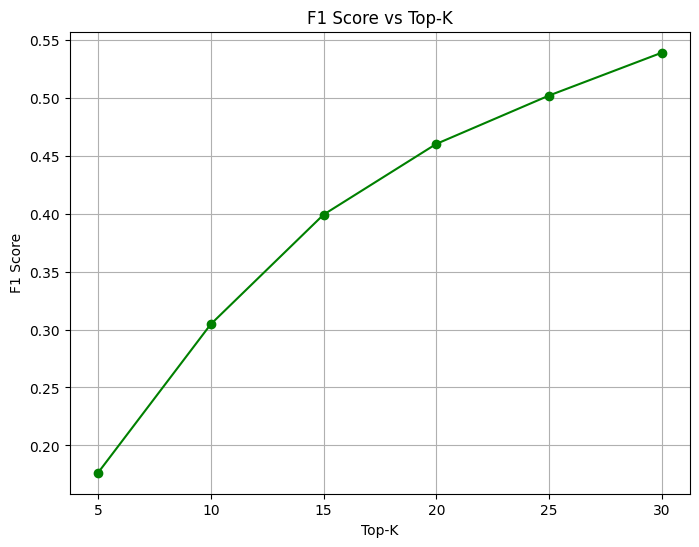

Fold 3/5
Top-5 Results:
Precision: 0.5143, Recall: 0.1072, F1-Score: 0.1693
----------------------------------------
Top-10 Results:
Precision: 0.5381, Recall: 0.2340, F1-Score: 0.3052
----------------------------------------
Top-15 Results:
Precision: 0.5302, Recall: 0.3413, F1-Score: 0.3889
----------------------------------------
Top-20 Results:
Precision: 0.5095, Recall: 0.4351, F1-Score: 0.4387
----------------------------------------
Top-25 Results:
Precision: 0.5124, Recall: 0.5493, F1-Score: 0.4961
----------------------------------------
Top-30 Results:
Precision: 0.5079, Recall: 0.6348, F1-Score: 0.5316
----------------------------------------


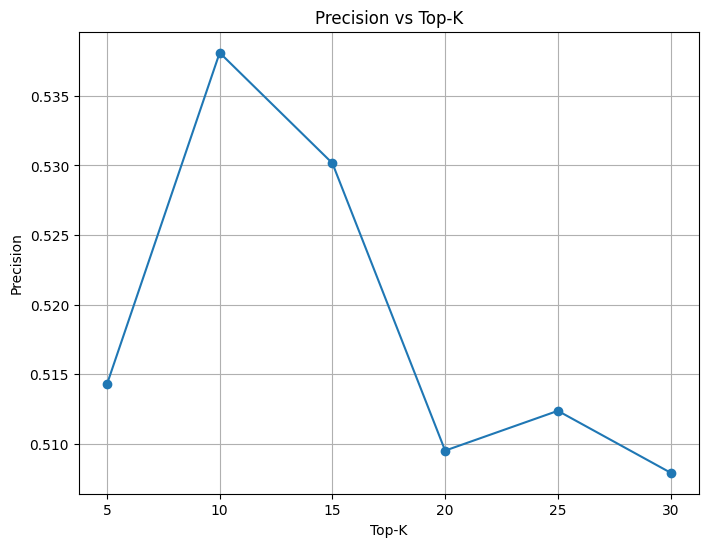

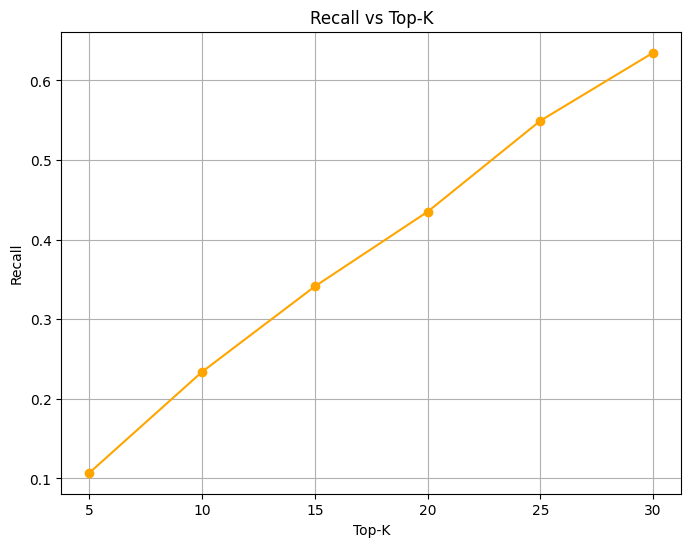

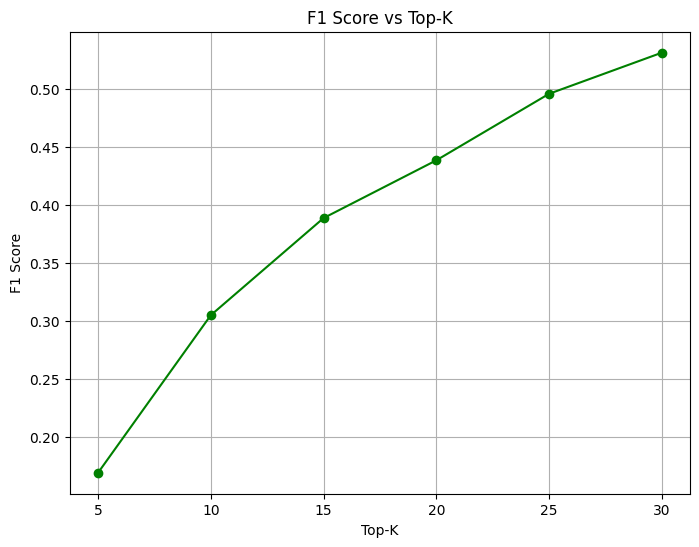

Fold 4/5
Top-5 Results:
Precision: 0.6900, Recall: 0.1526, F1-Score: 0.2379
----------------------------------------
Top-10 Results:
Precision: 0.5850, Recall: 0.2399, F1-Score: 0.3246
----------------------------------------
Top-15 Results:
Precision: 0.5567, Recall: 0.3387, F1-Score: 0.4027
----------------------------------------
Top-20 Results:
Precision: 0.5575, Recall: 0.4505, F1-Score: 0.4781
----------------------------------------
Top-25 Results:
Precision: 0.5540, Recall: 0.5552, F1-Score: 0.5327
----------------------------------------
Top-30 Results:
Precision: 0.5450, Recall: 0.6539, F1-Score: 0.5697
----------------------------------------


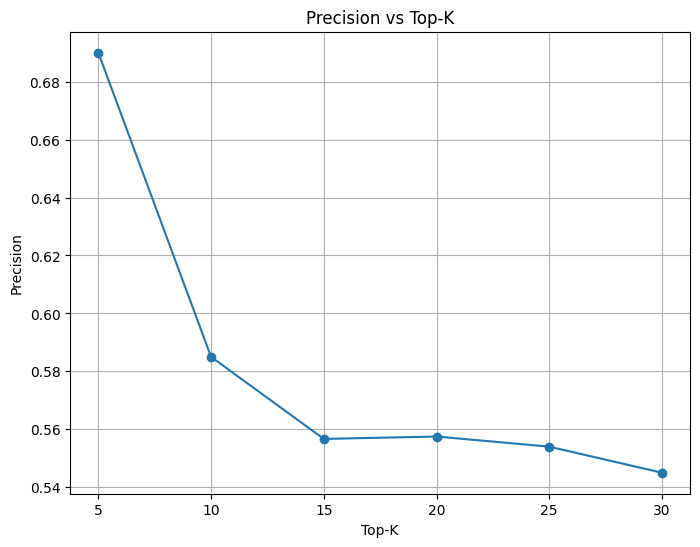

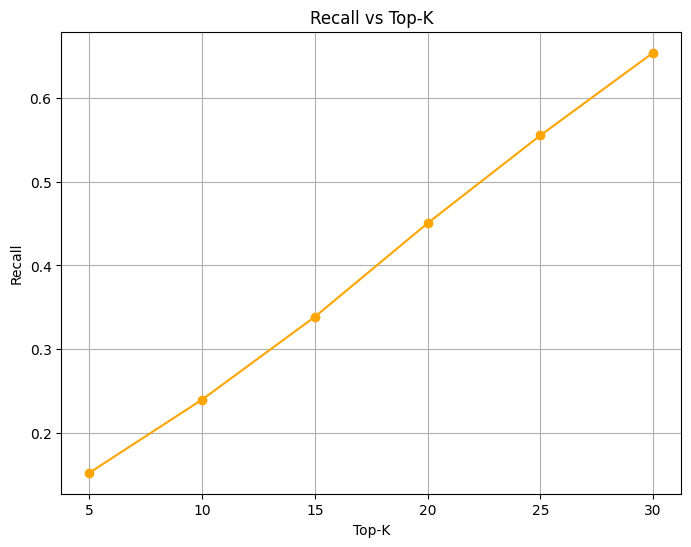

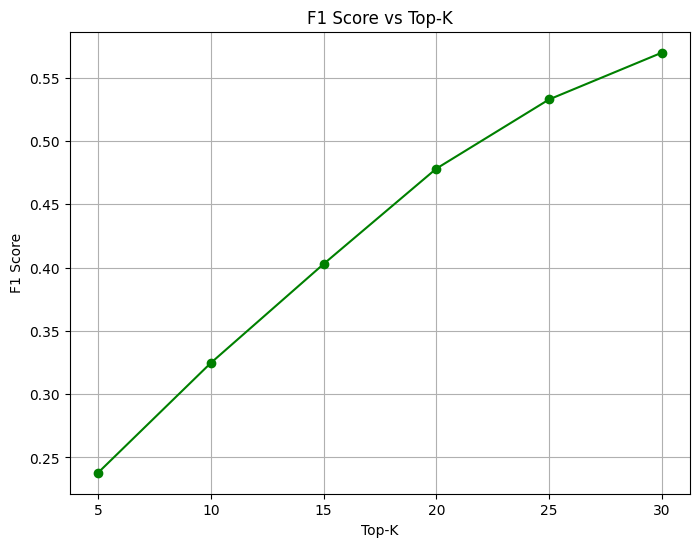

Fold 5/5
Top-5 Results:
Precision: 0.5300, Recall: 0.1316, F1-Score: 0.1876
----------------------------------------
Top-10 Results:
Precision: 0.4550, Recall: 0.2055, F1-Score: 0.2596
----------------------------------------
Top-15 Results:
Precision: 0.4833, Recall: 0.3157, F1-Score: 0.3582
----------------------------------------
Top-20 Results:
Precision: 0.4700, Recall: 0.3933, F1-Score: 0.4059
----------------------------------------
Top-25 Results:
Precision: 0.4480, Recall: 0.4620, F1-Score: 0.4335
----------------------------------------
Top-30 Results:
Precision: 0.4533, Recall: 0.5730, F1-Score: 0.4782
----------------------------------------


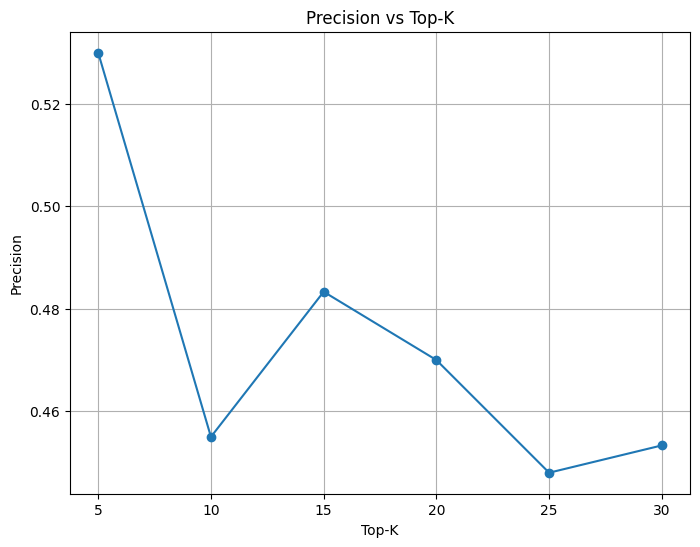

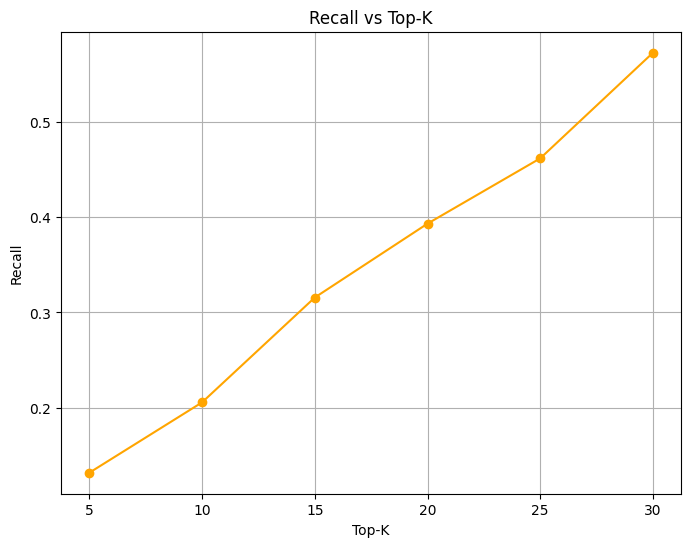

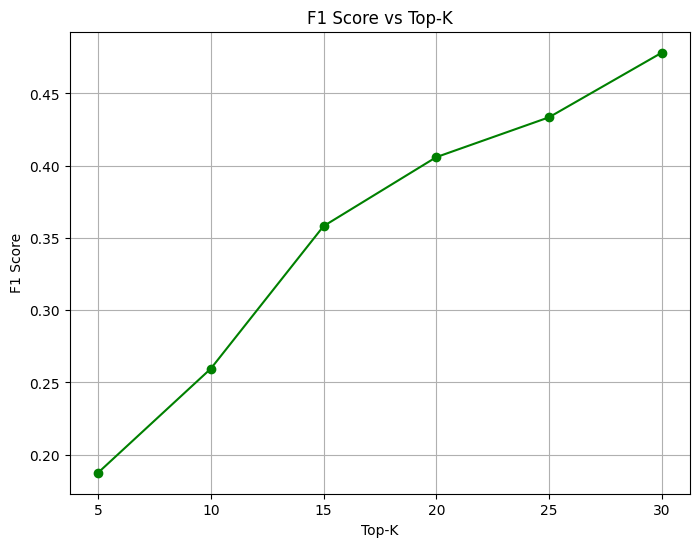


K-Fold Cross Validation Results (Averaged Across Folds):
Top-5 Results:
Precision: 0.5716, Recall: 0.1221, F1-Score: 0.1900
----------------------------------------
Top-10 Results:
Precision: 0.5413, Recall: 0.2263, F1-Score: 0.3009
----------------------------------------
Top-15 Results:
Precision: 0.5375, Recall: 0.3351, F1-Score: 0.3897
----------------------------------------
Top-20 Results:
Precision: 0.5255, Recall: 0.4303, F1-Score: 0.4480
----------------------------------------
Top-25 Results:
Precision: 0.5174, Recall: 0.5262, F1-Score: 0.4951
----------------------------------------
Top-30 Results:
Precision: 0.5117, Recall: 0.6211, F1-Score: 0.5325
----------------------------------------
Top-5 Results:
Precision: 0.5538, Recall: 0.1019, F1-Score: 0.1681
----------------------------------------
Top-10 Results:
Precision: 0.5423, Recall: 0.2173, F1-Score: 0.2965
----------------------------------------
Top-15 Results:
Precision: 0.5436, Recall: 0.3324, F1-Score: 0.3923
----

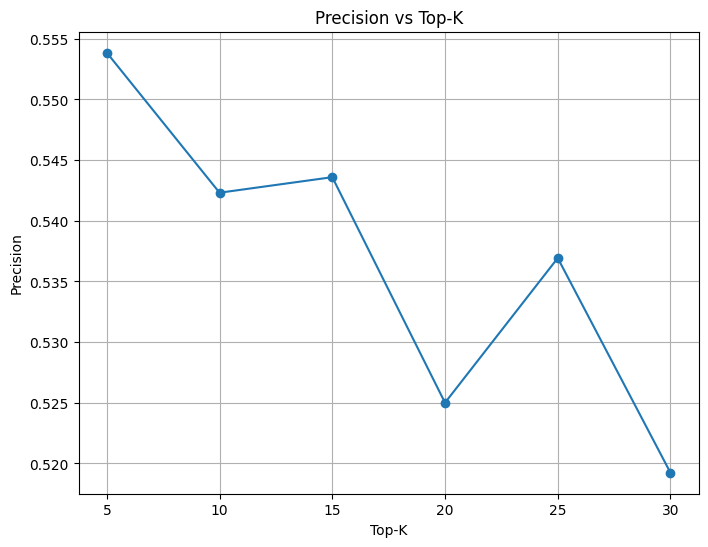

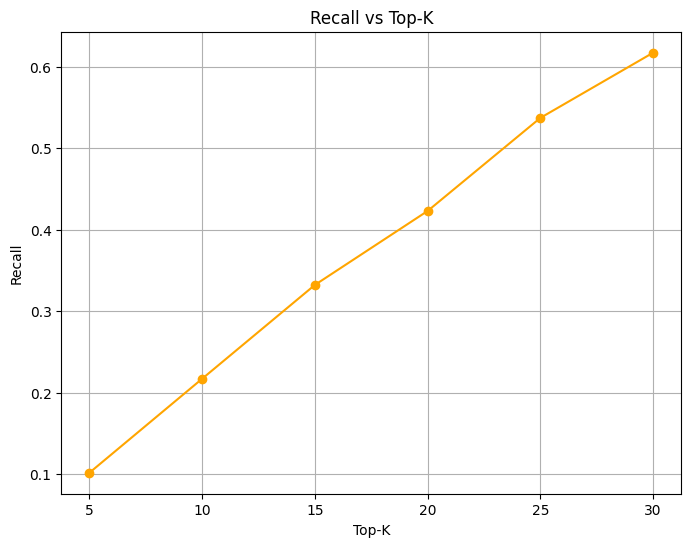

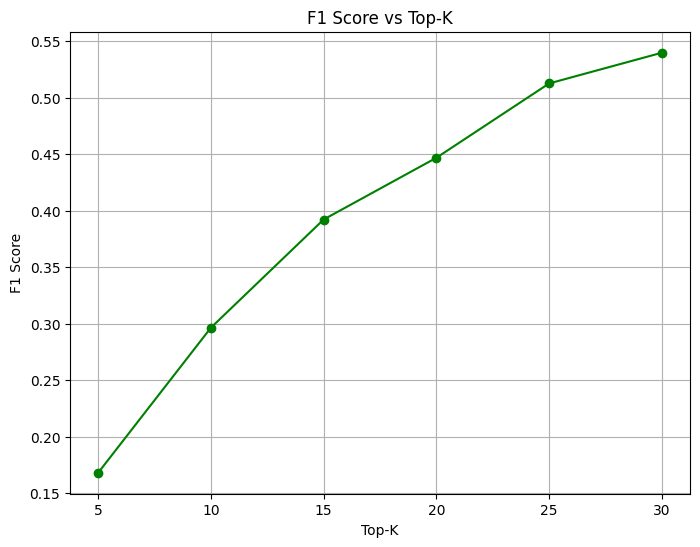

In [12]:
5# Updated main code to run K-Fold Cross Validation
train_admissions, test_admissions, train_embending_symptoms, test_embending_symptoms, train_embending_diagnosis, test_embending_diagnosis = train_test_split_admissions(admissions, embendings_symptoms, embendings_diagnosis)
#train_admissions, test_admissions, train_embending_symptoms, test_embending_symptoms, train_embending_diagnosis, test_embending_diagnosis = k_fold_cross_validation(admissions, embendings_symptoms, embendings_diagnosis, k=5, top_k_values=TOP_K_VALUES)
k_fold_cross_validation(train_admissions, train_embending_symptoms, train_embending_diagnosis, k=5, top_k_values=TOP_K_VALUES)

precision_scores, recall_scores, f1_scores = evaluate_model(train_admissions, test_admissions,train_embending_symptoms, test_embending_symptoms,train_embending_diagnosis, test_embending_diagnosis,TOP_K_VALUES)
